In [1071]:
# In this notebook I track and visualize COVID-19 data
# along with some simple modelling

# the data is taken 
# from https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv
# many thanks to Devakumar kp

# Imports

In [1072]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap
import seaborn as sns
sns.set_style("darkgrid")
import calmap

from datetime import datetime, timedelta
from itertools import chain
import functools

import copy

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# to suppress some annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Utility functions

In [1073]:
# draw the World map using basemaps
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.75, color='w')
        
# return time-series for given country/province
def get_ts(dataset, country, 
           cases_list=['Confirmed', 'Active', 'Deaths', 'Recovered'], 
           province=None):
    if province:
        df = dataset[(dataset['Country/Region'] == country) 
                    & (dataset['Province/State'] == province)]
    else:
        df = dataset[(dataset['Country/Region'] == country) 
                    & (dataset['Province/State'].isin([country]))]
    
    df = df.set_index('Date')[cases_list]
    df_new = df.diff()
    
    # add daily change in <cases_list> stats
    df_new.columns = ['New ' + case for case in cases_list]
    df_new.fillna(method='bfill', inplace=True)
    df_new=df_new.astype(int)
    
    return df.join(df_new)

# return dictionary <country> : <time-series>, for countries from 
def get_ts_global(dataset, countries_list, 
                  cases_list=['Confirmed', 'Active', 'Deaths', 'Recovered']):
    ts_dict = {}
    for country in countries_list:
        ts_dict[country] = get_ts(dataset, country, cases_list)
    
    ts_dict['World'] = functools.reduce(lambda left,right: 
                                        left + right, list(ts_dict.values()))
    if 'China' in countries_list:
        ts_dict['World_outside_China'] = ts_dict['World'] - ts_dict['China']   
    
    return ts_dict

# returns list of countries ranked by given criteria
def get_top_countries(dataset, n, date, keys_list=['Confirmed'], 
                      drop_list=[], asc_order=[False] ):
    data = dataset[dataset['Date'] == date]
    data.drop(data[data['Province/State']!=data['Country/Region']].index, 
              inplace=True)
    data.drop(data[data['Country/Region'].isin(drop_list)].index, 
              inplace=True)
    data.sort_values(keys_list, inplace=True, ascending=asc_order)
    return list(data['Country/Region'])[0:n]

# extends ts for <num_days> (to fill with predicted values)
def extend_ts(ts, num_days):
    new_index_list = list(ts.index)
    nan_row = {it:np.nan for it in list(ts.columns)}
    ext_ts = ts
    for _ in range(num_days):
        new_index_list.append(max(new_index_list) + timedelta(days=1))
        ext_ts = ext_ts.append(nan_row, ignore_index=True)
    ext_ts.index, ext_ts['Date'] = new_index_list, new_index_list
    return ext_ts

# converts ts to 'SIR-format' 
def ts_to_sir(ts, population, conf_threshold=100):
    sir_ts = ts[['Confirmed', 'Active', 'Deaths','Recovered']]
    sir_ts = sir_ts[sir_ts['Confirmed'] >= conf_threshold]
    sir_ts['S'] = ([population]*len(sir_ts) - sir_ts['Confirmed'])/population  
    sir_ts['I'] = sir_ts['Active']/population
    sir_ts['R'] = (sir_ts['Deaths'] + sir_ts['Recovered'])/population
    sir_ts.drop(['Confirmed', 'Active', 'Deaths','Recovered'], axis='columns', 
                inplace=True)
    return sir_ts

# Data Preparation

In [1074]:
DATA = pd.read_csv("covid_19_clean_complete.csv",  parse_dates=['Date'])

# add active cases
DATA['Active'] = DATA['Confirmed'] - DATA['Deaths'] - DATA['Recovered']

# add totals
dates_list = list(DATA['Date'].unique())
countries_list = list(DATA['Country/Region'].unique()) 

for country in countries_list:
    df = DATA[DATA['Country/Region'] == country]
    provinces = list(df['Province/State'].unique())
    if country in provinces:
        continue
    for date in dates_list:
        province = country
        lat = float(df[(df['Date'] == date)].Lat.unique()[0])
        long = float(df[(df['Date'] == date)].Long.unique()[0])
        confirmed = df[df['Date'] == date]['Confirmed'].sum()
        deaths = df[df['Date'] == date]['Deaths'].sum()
        recovered = df[df['Date'] == date]['Recovered'].sum()
        active = df[df['Date'] == date]['Active'].sum()
        DATA.loc[len(DATA)] = [province, country, lat, long, date, confirmed,\
                               deaths, recovered, active]

DATA = DATA[DATA['Province/State'].notna()] 
DATA.sort_values(['Date', 'Confirmed'], inplace=True, ascending=[True,False])

print(f"Includes data as of {DATA['Date'].max()}")
print("DF format: ")
DATA.head(3)

Includes data as of 2020-05-05 00:00:00
DF format: 


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
31080,China,China,31.8257,117.2264,2020-01-22,548,17,28,503
62,Hubei,China,30.9756,112.2707,2020-01-22,444,17,28,399
54,Guangdong,China,23.3417,113.4244,2020-01-22,26,0,0,26


# COVID-2019 Global Spread

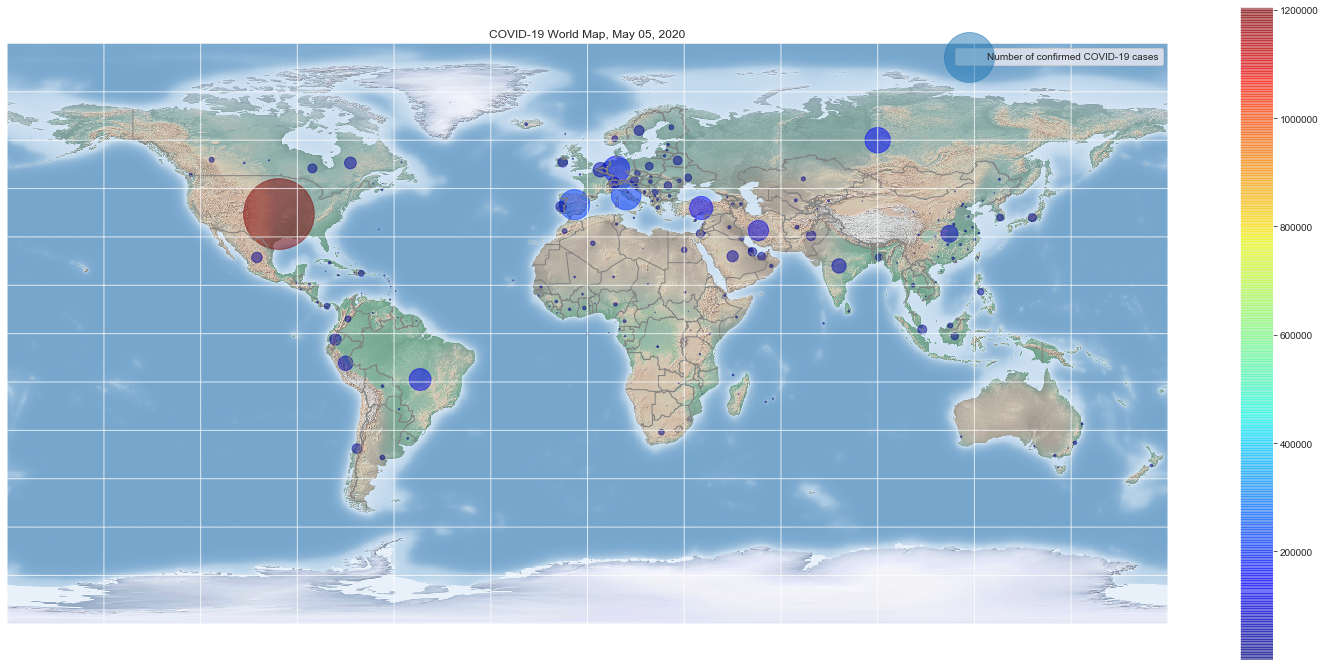

In [1075]:
try:
    from inspect import cleandoc as dedent
except ImportError:
    # Deprecated as of version 3.1. 
    # Not quite the same as textwrap.dedent.
    from matplotlib.cbook import dedent

# The World Map of COVID-19
now = DATA[DATA['Date'] == DATA['Date'].max()]
for countrie in countries_list:
    if len(now[now['Country/Region']==countrie].index) > 1:
        now.drop(now[(now['Country/Region']==countrie) &\
                     (now['Province/State']==countrie)].index, inplace=True)

fig = now.plot(figsize=(26,12), kind="scatter", title="COVID-19 World Map, " \
               + str(DATA['Date'].max().strftime("%B %d, %Y")), 
               x="Long", y="Lat", label="Number of confirmed COVID-19 cases", 
               s=(now["Confirmed"]/now["Confirmed"].max())*5000, 
               c=now["Confirmed"], cmap=plt.get_cmap("jet"), colorbar=True, 
               legend=True, sharex=False, alpha=0.5, 
               xlim=(-180, 180), ylim=(-90, 90))
m = Basemap(projection='cyl', resolution="h",
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
m.drawcountries(color="gray", linewidth=1)
draw_map(m)
plt.axis('off')
plt.show()

In [1076]:
# by-counitry time series
ts = get_ts_global(DATA,countries_list)

In [1077]:
# COVID-19 cases across the World (last N days)
N = 14
ts['World'].tail(N).style.background_gradient(subset=pd.IndexSlice[:, ['Confirmed','New Confirmed']],\
                                               cmap='Reds', low=0, high=0.75)\
                          .background_gradient(subset=pd.IndexSlice[:, ['Active','New Active']],\
                                               cmap='Blues', low=0, high=0.75)\
                          .background_gradient(subset=pd.IndexSlice[:, ['Deaths','New Deaths']],\
                                               cmap='Purples', low=0, high=0.75)\
                          .background_gradient(subset=pd.IndexSlice[:, ['Recovered','New Recovered']],\
                                               cmap='Greens', low=0, high=0.75)\

,Confirmed,Active,Deaths,Recovered,New Confirmed,New Active,New Deaths,New Recovered
Date,,,,,,,,
2020-04-22 00:00:00,2624736,1747099,186914,690723,75566,40330,6677,28559
2020-04-23 00:00:00,2708542,1795936,193667,718939,83806,48837,6753,28216
2020-04-24 00:00:00,2795870,1826995,199999,768876,87328,31059,6332,49937
2020-04-25 00:00:00,2881135,1879241,206187,795707,85265,52246,6188,26831
2020-04-26 00:00:00,2955028,1921959,209900,823169,73893,42718,3713,27462
2020-04-27 00:00:00,3023717,1960105,214484,849128,68689,38146,4584,25959
2020-04-28 00:00:00,3097185,1995200,220799,881186,73468,35095,6315,32058
2020-04-29 00:00:00,3172282,2023240,227665,921377,75097,28040,6866,40191
2020-04-30 00:00:00,3256848,2037984,233357,985507,84566,14744,5692,64130


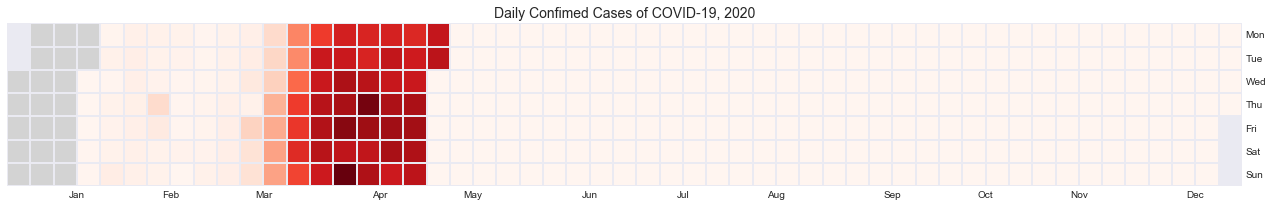

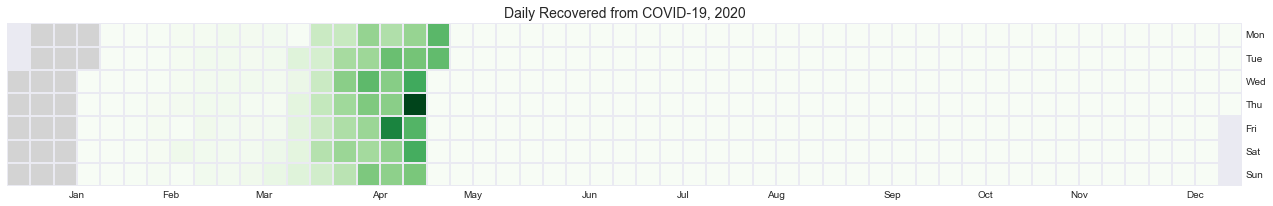

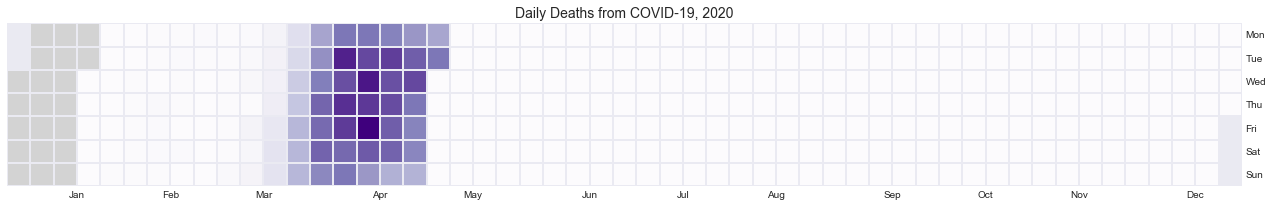

In [1078]:
# COVID-19 World Calendar
days = pd.date_range(DATA["Date"].min(), periods=len(DATA["Date"]), freq='D')
conf_events = pd.Series(ts['World']['New Confirmed'], index=days)
rec_events = pd.Series(ts['World']['New Recovered'], index=days)
dth_events = pd.Series(ts['World']['New Deaths'], index=days)

plt.figure(figsize=(26,3))
plt.title('Daily Confimed Cases of COVID-19, 2020', fontsize=14)
calmap.yearplot(conf_events, cmap='Reds', fillcolor='lightgrey')
plt.show()

plt.figure(figsize=(26,3))
plt.title('Daily Recovered from COVID-19, 2020', fontsize=14)
calmap.yearplot(rec_events, year=2020, cmap='Greens', fillcolor='lightgrey')
plt.show()

plt.figure(figsize=(26,3))
plt.title('Daily Deaths from COVID-19, 2020', fontsize=14)
calmap.yearplot(dth_events, year=2020, cmap='Purples', fillcolor='lightgrey')
plt.show()

# Covid-19 Worldwide dynamics

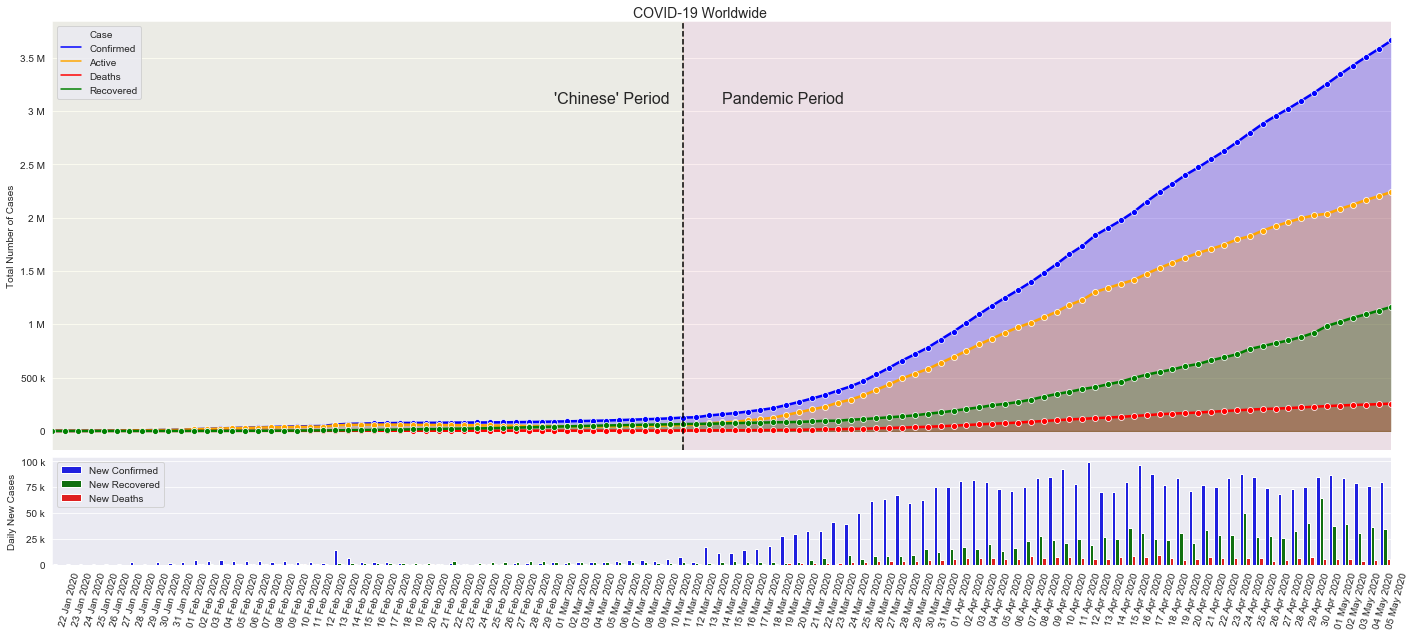

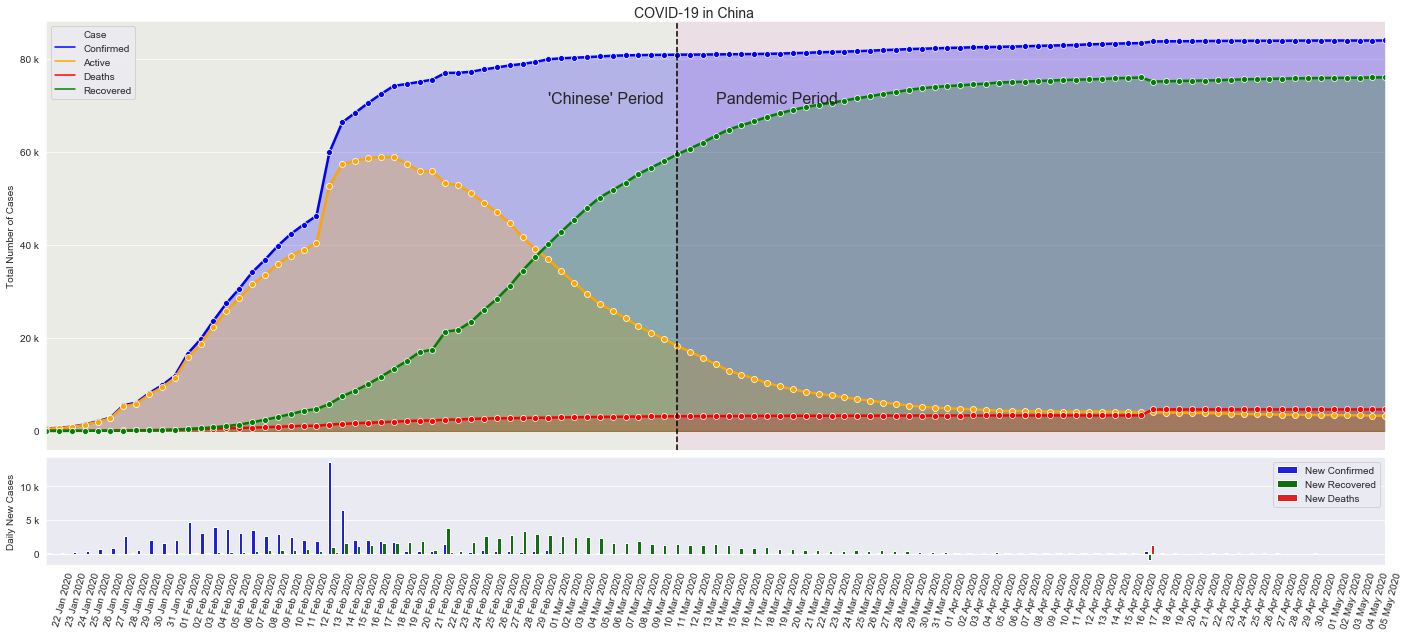

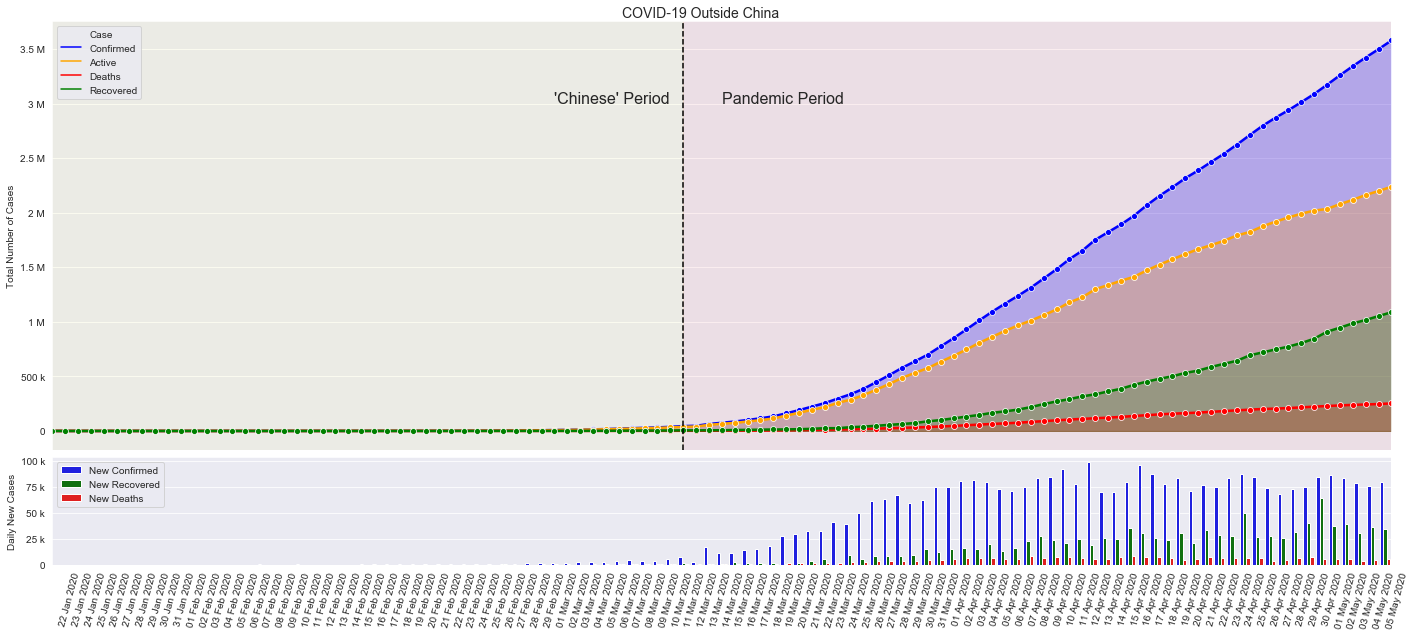

In [1079]:
# World Dynamics
world = ts['World']
world['Date'] = list(world.index)
cases = ['Confirmed', 'Active', 'Deaths', 'Recovered'] 
day_cases = ['New Confirmed', 'New Recovered', 'New Deaths']

world_melt = pd.melt(world, id_vars=['Date'], value_vars=cases, 
                     var_name='Case', value_name='Number')

world_melt_day = pd.melt(world, id_vars=['Date'], value_vars=day_cases, 
                         var_name='Case', value_name='Number')

fig = plt.figure(figsize=(24,10)) 
fig.suptitle("COVID-19 Worldwide", fontsize=14, y=0.9)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.025) 

ax0 = plt.subplot(gs[0])
ax0.set_title("")
ax0 = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   palette=['blue', 'orange', 'red', 'green'], 
                   linewidth=2.5, data=world_melt)

ax0.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5, 
            label="'Chinese'/Pandemic Period")

ax0.axvspan(world['Date'].min(), world['Date']['2020-03-11'], 
            alpha=0.05, color='yellow')
ax0.axvspan(world['Date']['2020-03-11'], world['Date'].max(), 
            alpha=0.05, color='red')
ax0.text(world['Date']['2020-03-01'], ax0.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
ax0.text(world['Date']['2020-03-14'], ax0.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

l1 = ax0.lines[0]
l2 = ax0.lines[1]
l3 = ax0.lines[2]
l4 = ax0.lines[3]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
x4 = l4.get_xydata()[:,0]
y4 = l4.get_xydata()[:,1]
ax0.fill_between(x1,y1, color="blue", alpha=0.25)
ax0.fill_between(x2,y2, color="orange", alpha=0.25)
ax0.fill_between(x3,y3, color="red", alpha=0.25)
ax0.fill_between(x4,y4, color="green", alpha=0.25)

ax0.set_ylabel("Total Number of Cases")
ax0.get_xaxis().set_visible(False)
ax0.yaxis.set_major_formatter(ticker.EngFormatter())

ax1 = plt.subplot(gs[1])
ax1 = sns.barplot(x='Date', y='Number', hue='Case', 
                   palette=['blue', 'green', 'red'], 
                   data=world_melt_day)

ax1.set_ylabel("Daily New Cases")
ax1.set_xlabel('')
ax1.set_xticklabels(list(world_melt_day['Date'].dt.strftime("%d %b %Y")), 
                    rotation=75, ha='left')
ax1.yaxis.set_major_formatter(ticker.EngFormatter())

ax0.set_xlim((world_melt_day['Date'].min(), world_melt_day['Date'].max()))
plt.legend()
plt.show()


#------------------------------------------------------------------------------
# China
china = ts['China']
china['Date'] = list(world.index)
cases = ['Confirmed', 'Active', 'Deaths', 'Recovered'] 
day_cases = ['New Confirmed', 'New Recovered', 'New Deaths']

china_melt = pd.melt(china, id_vars=['Date'], value_vars=cases, 
                     var_name='Case', value_name='Number')

china_melt_day = pd.melt(china, id_vars=['Date'], value_vars=day_cases, 
                         var_name='Case', value_name='Number')

fig = plt.figure(figsize=(24,10)) 
fig.suptitle("COVID-19 in China", fontsize=14, y=0.9)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.025) 

ax0 = plt.subplot(gs[0])
ax0.set_title("")
ax0 = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   palette=['blue', 'orange', 'red', 'green'], 
                   linewidth=2.5, data=china_melt)

ax0.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5, 
            label="'Chinese'/Pandemic Period")

ax0.axvspan(china['Date'].min(), china['Date']['2020-03-11'], 
            alpha=0.05, color='yellow')
ax0.axvspan(china['Date']['2020-03-11'], china['Date'].max(), 
            alpha=0.05, color='red')
ax0.text(china['Date']['2020-03-01'], ax0.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
ax0.text(china['Date']['2020-03-14'], ax0.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

l1 = ax0.lines[0]
l2 = ax0.lines[1]
l3 = ax0.lines[2]
l4 = ax0.lines[3]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
x4 = l4.get_xydata()[:,0]
y4 = l4.get_xydata()[:,1]
ax0.fill_between(x1,y1, color="blue", alpha=0.25)
ax0.fill_between(x2,y2, color="orange", alpha=0.25)
ax0.fill_between(x3,y3, color="red", alpha=0.25)
ax0.fill_between(x4,y4, color="green", alpha=0.25)

ax0.set_ylabel("Total Number of Cases")
ax0.get_xaxis().set_visible(False)
ax0.yaxis.set_major_formatter(ticker.EngFormatter())

ax1 = plt.subplot(gs[1])
ax1 = sns.barplot(x='Date', y='Number', hue='Case', 
                   palette=['blue', 'green', 'red'], 
                   data=china_melt_day)

ax1.set_ylabel("Daily New Cases")
ax1.set_xlabel('')
ax1.set_xticklabels(list(china_melt_day['Date'].dt.strftime("%d %b %Y")), 
                    rotation=75, ha='left')
ax1.yaxis.set_major_formatter(ticker.EngFormatter())

ax0.set_xlim((world_melt_day['Date'].min(), world_melt_day['Date'].max()))
plt.legend()
plt.show()


#------------------------------------------------------------------------------
# World outside China
woc = ts['World_outside_China']
woc['Date'] = list(woc.index)
cases = ['Confirmed', 'Active', 'Deaths', 'Recovered'] 
day_cases = ['New Confirmed', 'New Recovered', 'New Deaths']

woc_melt = pd.melt(woc, id_vars=['Date'], value_vars=cases, 
                     var_name='Case', value_name='Number')

woc_melt_day = pd.melt(woc, id_vars=['Date'], value_vars=day_cases, 
                         var_name='Case', value_name='Number')

fig = plt.figure(figsize=(24,10)) 
fig.suptitle("COVID-19 Outside China", fontsize=14, y=0.9)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.025) 

ax0 = plt.subplot(gs[0])
ax0.set_title("")
ax0 = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   palette=['blue', 'orange', 'red', 'green'], 
                   linewidth=2.5, data=woc_melt)

ax0.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5, 
            label="'Chinese'/Pandemic Period")

ax0.axvspan(woc['Date'].min(), woc['Date']['2020-03-11'], 
            alpha=0.05, color='yellow')
ax0.axvspan(woc['Date']['2020-03-11'], woc['Date'].max(), 
            alpha=0.05, color='red')
ax0.text(woc['Date']['2020-03-01'], ax0.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
ax0.text(woc['Date']['2020-03-14'], ax0.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

l1 = ax0.lines[0]
l2 = ax0.lines[1]
l3 = ax0.lines[2]
l4 = ax0.lines[3]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
x4 = l4.get_xydata()[:,0]
y4 = l4.get_xydata()[:,1]
ax0.fill_between(x1,y1, color="blue", alpha=0.25)
ax0.fill_between(x2,y2, color="orange", alpha=0.25)
ax0.fill_between(x3,y3, color="red", alpha=0.25)
ax0.fill_between(x4,y4, color="green", alpha=0.25)

ax0.set_ylabel("Total Number of Cases")
ax0.get_xaxis().set_visible(False)
ax0.yaxis.set_major_formatter(ticker.EngFormatter())

ax1 = plt.subplot(gs[1])
ax1 = sns.barplot(x='Date', y='Number', hue='Case', 
                   palette=['blue', 'green', 'red'], 
                   data=woc_melt_day)

ax1.set_ylabel("Daily New Cases")
ax1.set_xlabel('')
ax1.set_xticklabels(list(china_melt_day['Date'].dt.strftime("%d %b %Y")), 
                    rotation=75, ha='left')
ax1.yaxis.set_major_formatter(ticker.EngFormatter())

ax0.set_xlim((woc_melt_day['Date'].min(), woc_melt_day['Date'].max()))
plt.legend()
plt.show()

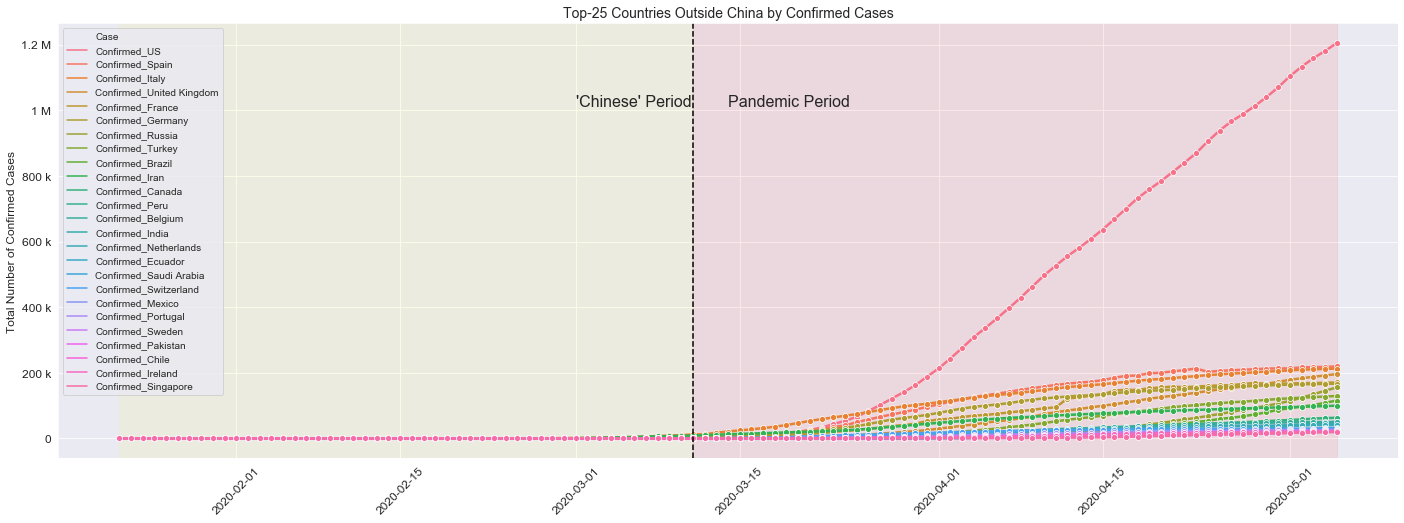

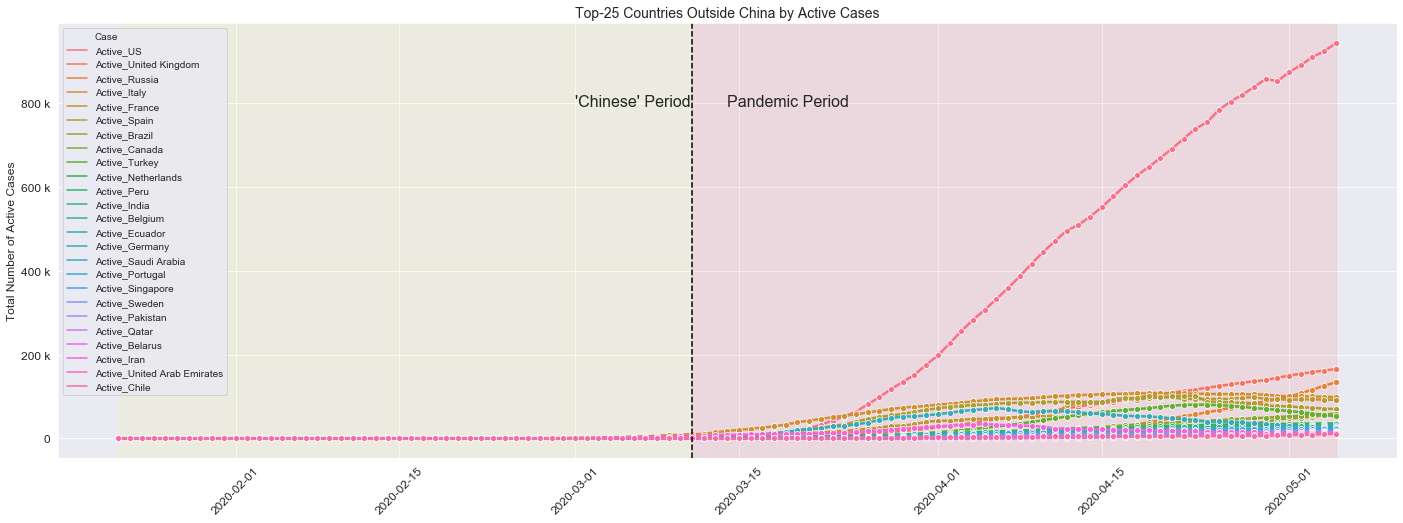

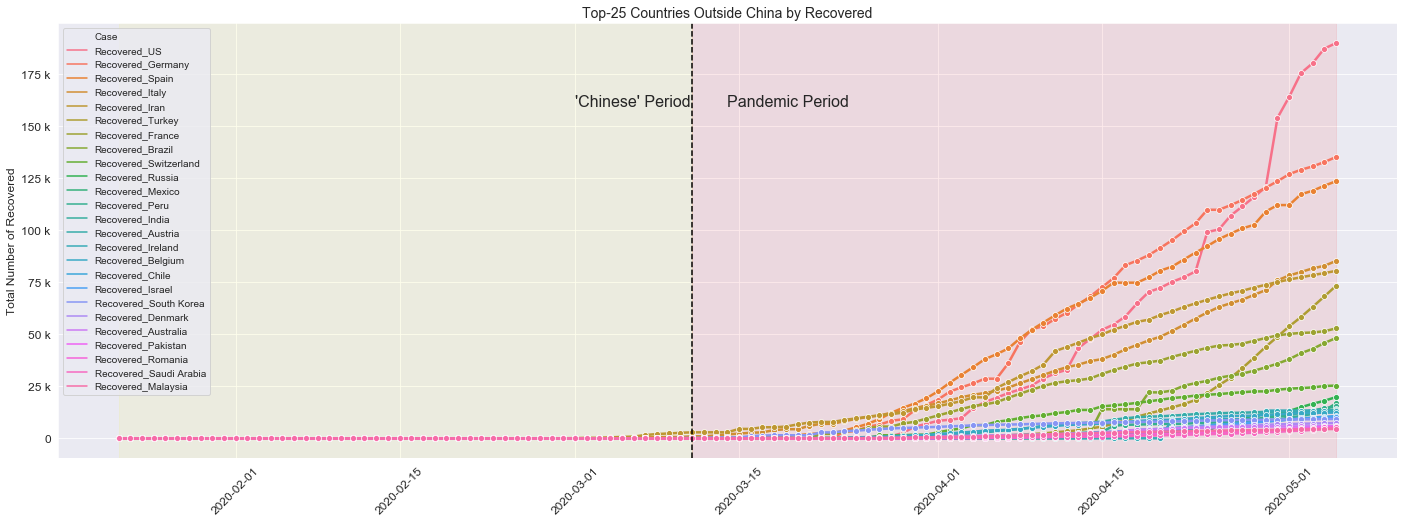

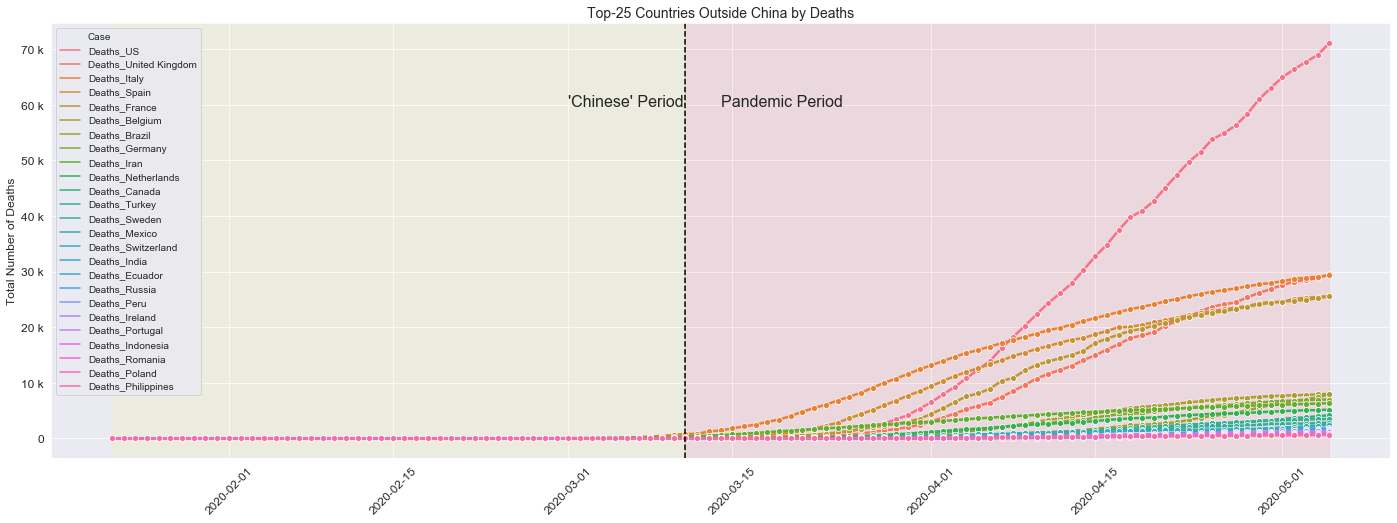

In [1080]:
# TOP-N
N = 25

# top-N countries outside China by CONFIRMED cases
top_conf = []
cases = ['Confirmed']
for country in get_top_countries(DATA, N, DATA['Date'].max(), cases, ['China']):
    country_df = copy.deepcopy(ts[country])
    for column in list(country_df.columns):
        if not column in cases:
            country_df.drop(column, axis='columns', inplace=True)
    new_col_names={}
    for column in cases:
        new_col_names[column] = column+'_'+country
    country_df.rename(new_col_names, axis='columns', inplace=True)
    top_conf.append(country_df)

top_ts_df_confirmed = functools.reduce(lambda left,right:\
                                          left.join(right), top_conf)
top_ts_df_confirmed['Date'] = list(top_ts_df_confirmed.index)

plt.figure(figsize=(24,8))
plt.title(f"Top-{N} Countries Outside China by Confirmed Cases", fontsize=14)
top_melt = pd.melt(top_ts_df_confirmed, id_vars=['Date'], 
                      value_vars=list(top_ts_df_confirmed.columns)[:-1], 
                      var_name='Case', value_name='Number')
fig = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   data=top_melt, linewidth=2.5)

x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)
plt.xlabel('')
plt.ylabel("Total Number of Confirmed Cases", fontsize=12)

plt.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5)

plt.text(world['Date']['2020-03-01'], fig.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
plt.text(world['Date']['2020-03-14'], fig.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

plt.axvspan(world['Date'].min(), world['Date']['2020-03-11'], 
            alpha=0.075, color='yellow')
plt.axvspan(world['Date']['2020-03-11'], world['Date'].max(), 
            alpha=0.075, color='red')

fig.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

#------------------------------------------------------------------------------
# top-N countries outside China by ACTIVE cases
top_act = []
cases = ['Active']
for country in get_top_countries(DATA, N, DATA['Date'].max(), cases, ['China']):
    country_df = copy.deepcopy(ts[country])
    for column in list(country_df.columns):
        if not column in cases:
            country_df.drop(column, axis='columns', inplace=True)
    new_col_names={}
    for column in cases:
        new_col_names[column] = column+'_'+country
    country_df.rename(new_col_names, axis='columns', inplace=True)
    top_act.append(country_df)

top_ts_df_active = functools.reduce(lambda left,right:\
                                       left.join(right), top_act)
top_ts_df_active['Date'] = list(top_ts_df_active.index)

plt.figure(figsize=(24,8))
plt.title(f"Top-{N} Countries Outside China by Active Cases", fontsize=14)

top_melt = pd.melt(top_ts_df_active, id_vars=['Date'], 
                      value_vars=list(top_ts_df_active.columns)[:-1], 
                      var_name='Case', value_name='Number')
fig = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   data=top_melt, linewidth=2.5)

plt.xlabel('')
plt.ylabel("Total Number of Active Cases", fontsize=12)
x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)

plt.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5)

plt.text(world['Date']['2020-03-01'], fig.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
plt.text(world['Date']['2020-03-14'], fig.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

plt.axvspan(world['Date'].min(), world['Date']['2020-03-11'], 
            alpha=0.075, color='yellow')
plt.axvspan(world['Date']['2020-03-11'], world['Date'].max(), 
            alpha=0.075, color='red')

fig.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

#------------------------------------------------------------------------------
# top-N countries outside China by Recovered
top_rec = []
cases = ['Recovered']
for country in get_top_countries(DATA, N, DATA['Date'].max(), cases, ['China']):
    country_df = copy.deepcopy(ts[country])
    for column in list(country_df.columns):
        if not column in cases:
            country_df.drop(column, axis='columns', inplace=True)
    new_col_names={}
    for column in cases:
        new_col_names[column] = column+'_'+country
    country_df.rename(new_col_names, axis='columns', inplace=True)
    top_rec.append(country_df)

top_ts_df_recovered = functools.reduce(lambda left,right:\
                                          left.join(right), top_rec)
top_ts_df_recovered['Date'] = list(top_ts_df_recovered.index) 

plt.figure(figsize=(24,8))
plt.title(f"Top-{N} Countries Outside China by Recovered", fontsize=14)

top_melt = pd.melt(top_ts_df_recovered, id_vars=['Date'], 
                      value_vars=list(top_ts_df_recovered.columns)[:-1], 
                      var_name='Case', value_name='Number')
fig = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   data=top_melt, linewidth=2.5)

x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)
plt.xlabel('')
plt.ylabel("Total Number of Recovered", fontsize=12)

plt.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5)

plt.text(world['Date']['2020-03-01'], fig.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
plt.text(world['Date']['2020-03-14'], fig.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

plt.axvspan(world['Date'].min(), world['Date']['2020-03-11'], 
            alpha=0.075, color='yellow')
plt.axvspan(world['Date']['2020-03-11'], world['Date'].max(), 
            alpha=0.075, color='red')

fig.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

#------------------------------------------------------------------------------
# top-N countries outside China by DEATHS
top_dth = []
cases = ['Deaths']
for country in get_top_countries(DATA, N, DATA['Date'].max(), cases, ['China']):
    country_df = copy.deepcopy(ts[country])
    for column in list(country_df.columns):
        if not column in cases:
            country_df.drop(column, axis='columns', inplace=True)
    new_col_names={}
    for column in cases:
        new_col_names[column] = column+'_'+country
    country_df.rename(new_col_names, axis='columns', inplace=True)
    top_dth.append(country_df)

top_ts_df_deaths = functools.reduce(lambda left,right:\
                                       left.join(right), top_dth)
top_ts_df_deaths['Date'] = list(top_ts_df_deaths.index) 

plt.figure(figsize=(24,8))
plt.title(f"Top-{N} Countries Outside China by Deaths", fontsize=14)

top_melt = pd.melt(top_ts_df_deaths, id_vars=['Date'], 
                      value_vars=list(top_ts_df_deaths.columns)[:-1], 
                      var_name='Case', value_name='Number')
fig = sns.lineplot(x='Date', y='Number', hue='Case', marker="o", 
                   data=top_melt, linewidth=2.5)

plt.xlabel('')
plt.ylabel("Total Number of Deaths", fontsize=12)
x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)

plt.axvline(x=world['Date']['2020-03-11'], color='k', 
            linestyle='--', linewidth=1.5)

plt.text(world['Date']['2020-03-01'], fig.get_ylim()[1]*0.8, 
         "'Chinese' Period", fontsize=16)
plt.text(world['Date']['2020-03-14'], fig.get_ylim()[1]*0.8, 
         "Pandemic Period", fontsize=16)

plt.axvspan(world['Date'].min(), world['Date']['2020-03-11'], 
            alpha=0.075, color='yellow')
plt.axvspan(world['Date']['2020-03-11'], world['Date'].max(), 
            alpha=0.075, color='red')

fig.yaxis.set_major_formatter(ticker.EngFormatter())

plt.show()


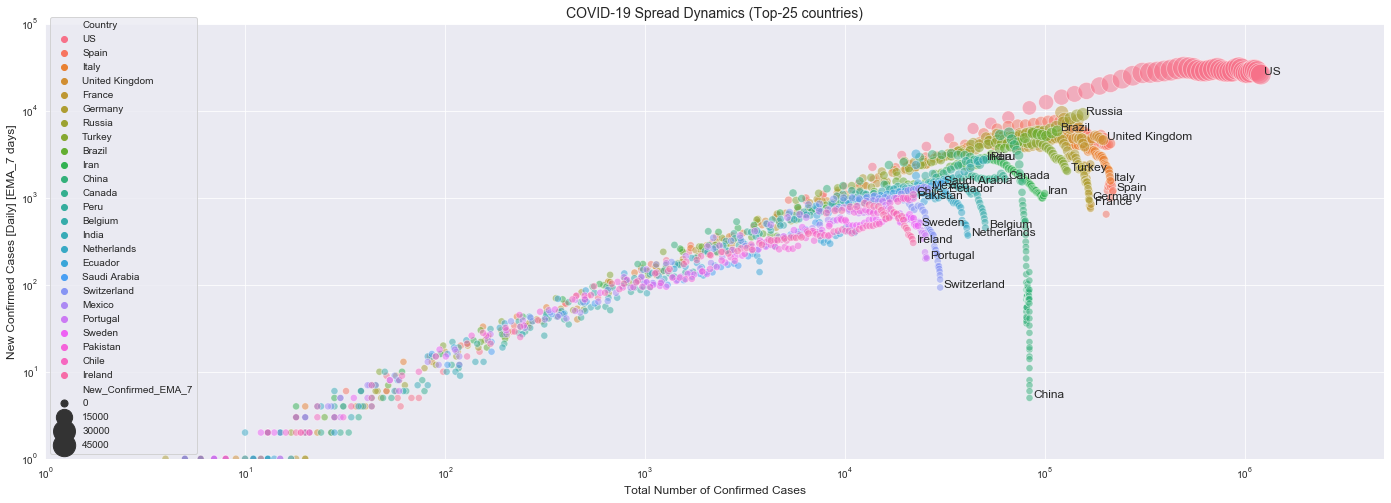

In [1081]:
# COVID-19 World Dynamics -- New Confirmed vs Total Confirmed cases 
# (Top-N countries log-log plot)
N = 25
top_list = get_top_countries(DATA, N, DATA['Date'].max(), ['Confirmed'])
for country in top_list:
    ts[country]['Country'] = country
    ts[country]['New_Confirmed_EMA_7'] = \
               ts[country]['New Confirmed'].ewm(span=7).mean().astype(int)
    
top_ts = functools.reduce(lambda left,right: left.append(right, sort=False), 
                          [ts[country] for country in top_list])

plt.figure(figsize=(24,8))
plt.title(f"COVID-19 Spread Dynamics (Top-{N} countries)" , fontsize=14)
fig = sns.scatterplot(x='Confirmed', y='New_Confirmed_EMA_7', 
                size='New_Confirmed_EMA_7', sizes=(50,500), 
                hue='Country', alpha=0.5, data=top_ts)
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim((1e0,1e5))
fig.set_xlim((1e0,5e6))

now = DATA['Date'].max()
for country in top_list:
    df = top_ts[top_ts['Country']==country]
    df = df[df.index == now]
    plt.text(int(df['Confirmed'])*(1 + 0.04), 
             int(df['New_Confirmed_EMA_7'])*(1 - 0.0), 
             country, fontsize=12)

plt.xlabel("Total Number of Confirmed Cases", fontsize=12)
plt.ylabel("New Confirmed Cases [Daily] [EMA_7 days]", fontsize=12)    

plt.show()

# Current situation (Latest data by Country)

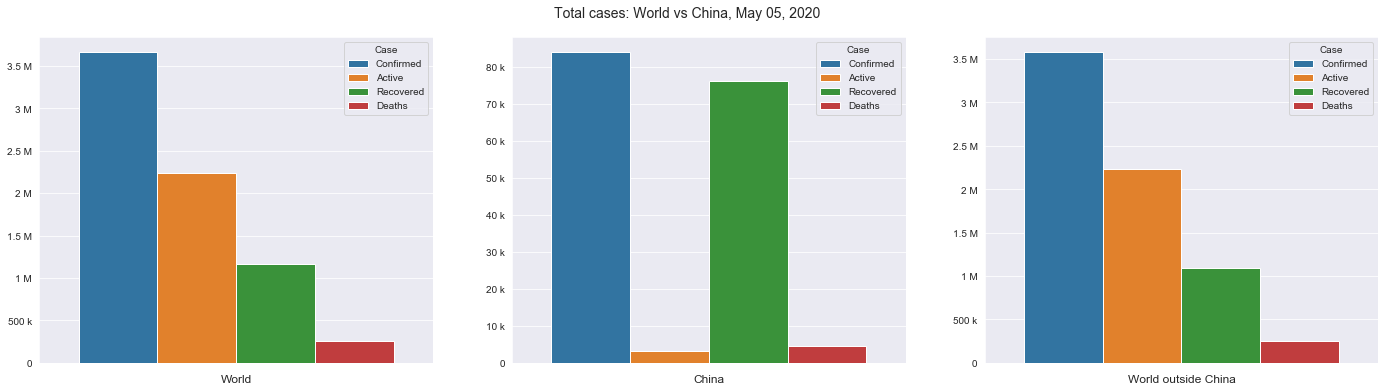

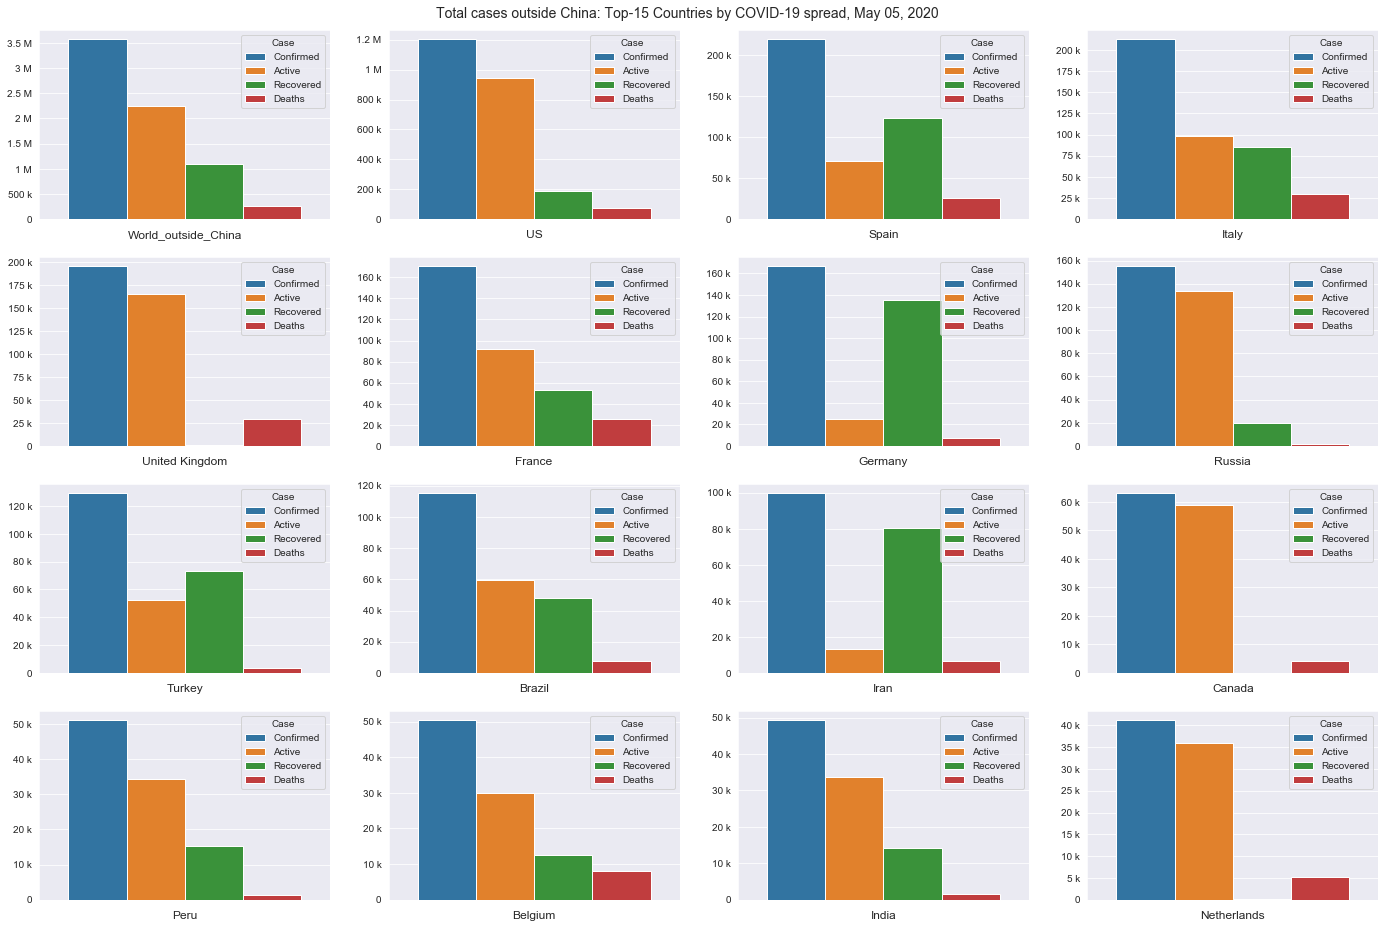

In [1082]:
# World vs China Now
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24, 6))
fig.suptitle("Total cases: World vs China, " + str(DATA['Date'].max().strftime("%B %d, %Y")), fontsize=14, y=0.95)
sns.barplot(x='Date', y='Number', hue='Case', 
            hue_order=['Confirmed', 'Active', 'Recovered', 'Deaths'], 
            data=world_melt[world_melt['Date'] == world_melt['Date'].max()], 
            ax=ax1)
ax1.set_ylabel('')
ax1.set_xlabel('World', fontsize=12)
ax1.set_xticklabels([])
ax1.yaxis.set_major_formatter(ticker.EngFormatter())

sns.barplot(x='Date', y='Number', hue='Case', 
            hue_order=['Confirmed', 'Active', 'Recovered', 'Deaths'], 
            data=china_melt[world_melt['Date'] == china_melt['Date'].max()],
            ax=ax2)
ax2.set_ylabel('')
ax2.set_xlabel('China', fontsize=12)
ax2.set_xticklabels([])
ax2.yaxis.set_major_formatter(ticker.EngFormatter())

sns.barplot(x='Date', y='Number', hue='Case', 
            hue_order=['Confirmed', 'Active', 'Recovered', 'Deaths'], 
            data=woc_melt[woc_melt['Date'] == woc_melt['Date'].max()],
            ax=ax3)
ax3.set_ylabel('')
ax3.set_xlabel('World outside China', fontsize=12)
ax3.set_xticklabels([])
ax3.yaxis.set_major_formatter(ticker.EngFormatter())

plt.show()

#------------------------------------------------------------------------------
# Top-15 countries now
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
top15_confirmed = ['World_outside_China'] 
top15_confirmed = top15_confirmed + get_top_countries(DATA, 15, DATA['Date'].max(), ['Confirmed'], ['China'])
top15_confirmed_df = {country:ts[country] for country in top15_confirmed}
top15_confirmed_mlt = {}
for country in top15_confirmed_df:
    top15_confirmed_df[country]['Date'] = list(top15_confirmed_df[country].index)
    top15_confirmed_mlt[country] = pd.melt(top15_confirmed_df[country][top15_confirmed_df[country]['Date']==DATA['Date'].max()], 
                                           id_vars=['Date'], value_vars=cases, var_name='Case', value_name='Number') 
    
fig, ax = plt.subplots(4,4, figsize = (24, 16))
ax = ax.flatten()
fig.suptitle("Total cases outside China: Top-15 Countries by COVID-19 spread, " +\
             str(DATA['Date'].max().strftime("%B %d, %Y")), fontsize=14, y=0.9)

for i,country in enumerate(top15_confirmed):
    sns.barplot(x='Date', y='Number', hue='Case', 
                hue_order=['Confirmed', 'Active', 'Recovered', 'Deaths'], 
                data=top15_confirmed_mlt[country], ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel(country, fontsize=12)
    ax[i].set_xticklabels([])
    ax[i].yaxis.set_major_formatter(ticker.EngFormatter())

plt.show()

# Mortality Statistics and Estimations

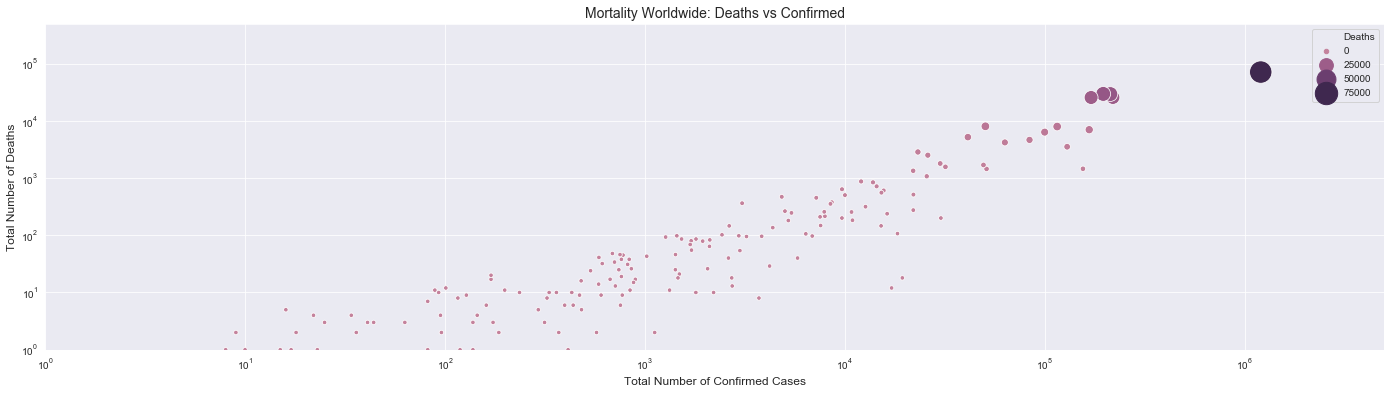

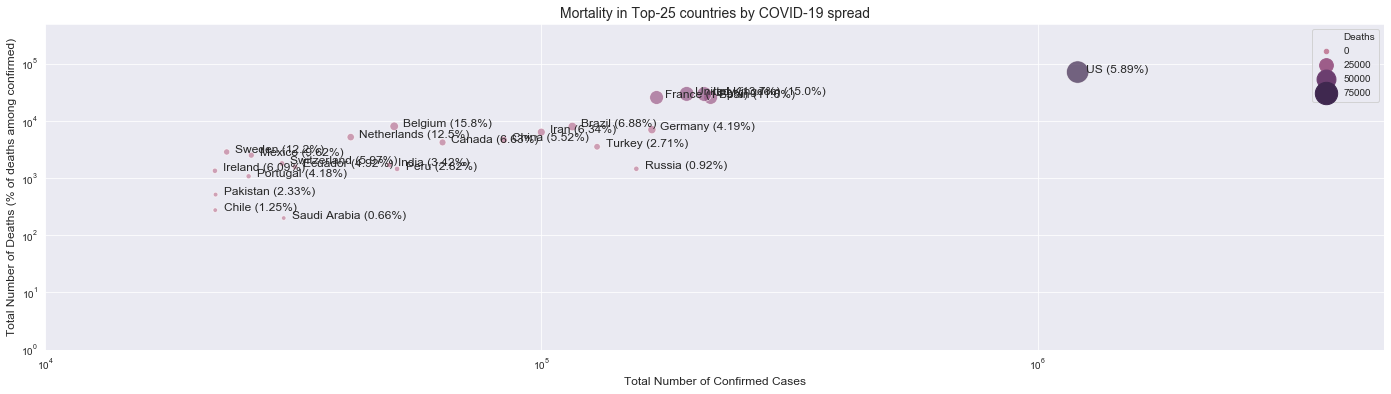

In [1083]:
# MORTALITY STATISCTICS

# World
Dead_vs_Conf = DATA[(DATA['Country/Region']==DATA['Province/State']) \
                    & (DATA['Date']==DATA['Date'].max())][['Country/Region', 'Confirmed', 'Deaths']]

cmap = sns.cubehelix_palette(8, dark=.2, light=.6, as_cmap=True)
sz = (20,500)

plt.figure(figsize=(24,6))
plt.title("Mortality Worldwide: Deaths vs Confirmed", fontsize=14)
fig = sns.scatterplot(x='Confirmed', y='Deaths', 
                size='Deaths', sizes=sz, 
                palette=cmap, hue='Deaths',
                legend='brief', data=Dead_vs_Conf)
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim((1e0,5e5))
fig.set_xlim((1e0,5e6))
plt.xlabel("Total Number of Confirmed Cases", fontsize=12)
plt.ylabel("Total Number of Deaths", fontsize=12)
plt.show()


#Top-25
plt.figure(figsize=(24,6))
plt.title("Mortality in Top-25 countries by COVID-19 spread", fontsize=14)
fig = sns.scatterplot(x='Confirmed', y='Deaths', 
                size='Deaths', sizes=sz, 
                palette=cmap, hue='Deaths', alpha=0.7,
                legend='brief', data=Dead_vs_Conf[:25])
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim((1e0,5e5))
fig.set_xlim((1e4,5e6))

countries = list(Dead_vs_Conf['Country/Region'])[0:25]
for country in countries:
    df = Dead_vs_Conf[Dead_vs_Conf['Country/Region']==country]
    rate = str(round(int(df['Deaths'])/int(df['Confirmed']),4)*100)[:4]
    plt.text(int(df['Confirmed'])*(1 + 0.04), int(df['Deaths'])*(1 - 0.0), 
             country+' ('+rate+'%)', fontsize=12)
plt.xlabel("Total Number of Confirmed Cases", fontsize=12)
plt.ylabel("Total Number of Deaths (% оf deaths among confirmed)", fontsize=12)
plt.show()


In [1084]:
# ESTIMATING MORTALITY RATE 

# 0) Naive approach: MR0 = Deaths_Cases(T)/Confirmed_Cases(T) 
#                          {at day T}
# This would be a correct estimation in case if the epidemic 
# is already finished and we have accurate enough 
# data for overall Deaths caused by disease 
# and the total number of Confirmed Cases of the disease.
# As of April 2020, MR0 estimation may be good enought only for
# countries such as China and South Korea, which seems 
# to be at the very end of epidemic.
# However, in the majority of countries epidemic is still ongoing 
# and there are lot's of people, who are infected, and the outcome is uncleare.


# 1) MR1 = <New_Deaths_Cases(T)/(New_Deaths_Cases(T)+New_Recovered_Cases(T))>

# Asumes that there are only 2 possible outcomes after some period delta_T - 
# infected person either recovers either dies and 
# Total_Outcomes(T) = Deaths_Cases(T)+Recovered_Cases(T).
# On pracrice, however, it is likely that 
# Total_Outcomes(T) > Deaths_Cases(T)+Recovered_Cases(T)
# (we have 3 actual outcomes - death, recovery, staying infected, 
# also unreported cases influence the final result significantly).
# Therfore, such an aproach may lead to massive overestimation of
# the mortality rate.On the other hand, in case if we use the latest data 

# Further I will not use MR1 

# 2) MR2 = <Deaths_Cases(T)/Confirmed_Cases(T-delta_T)>

# Assuming that the median period from case confirmation to death
# is equal delta_T, we should relate deaths at day T 
# to cases confirmed at day (T-delta_T).
# This would probably  be the most relevant estimate, 
# however, still not accurate, since the reported range of days 
# from first COVID-19 symptoms to death is quite wide (6-41 days) - 
# "Updated understanding of the outbreak of 2019 
# novel coronavirus (2019nCoV) in Wuhan, 
# China" - Journal of Medical Virology, Jan. 29, 2020

mr_stats = {}
for countrie in list(ts.keys()):
    df = ts[countrie]
    
    df['MR0'] = df['Deaths']/df['Confirmed']
    df['MR0'].fillna(0, inplace=True)
        
    df['Confirmed_Shift_7'] = df['Confirmed'].shift(7)
    df['Confirmed_Shift_7'].fillna(0, inplace=True)
    df['MR2'] = df['Deaths']/df['Confirmed_Shift_7']
    
    mr_stats[countrie] = {'MR0': round(100*df['MR0'].iloc[-1],1),
                          'MR2': round(100*df.tail(14)['MR2'].mean(),1)}
mr_stats_cw = {}
mr_stats_cw['World'] = {'MR0': round(100*ts['World']['MR0'].iloc[-1],1),
                        'MR2': round(100*ts['World'].tail(14)['MR2'].mean(),1)}
mr_stats_cw['China'] = {'MR0': round(100*ts['China']['MR0'].iloc[-1],1),
                        'MR2': round(100*ts['China'].tail(14)['MR2'].mean(),1)}
mr_stats_cw['Outside China'] = {'MR0': round(100*ts['World_outside_China']['MR0'].iloc[-1],1),
                      'MR2': round(100*ts['World_outside_China'].tail(14)['MR2'].mean(),1)}
    

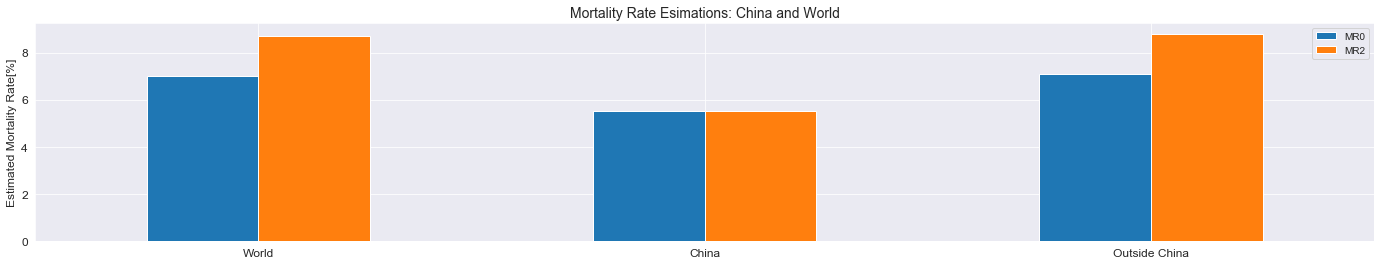

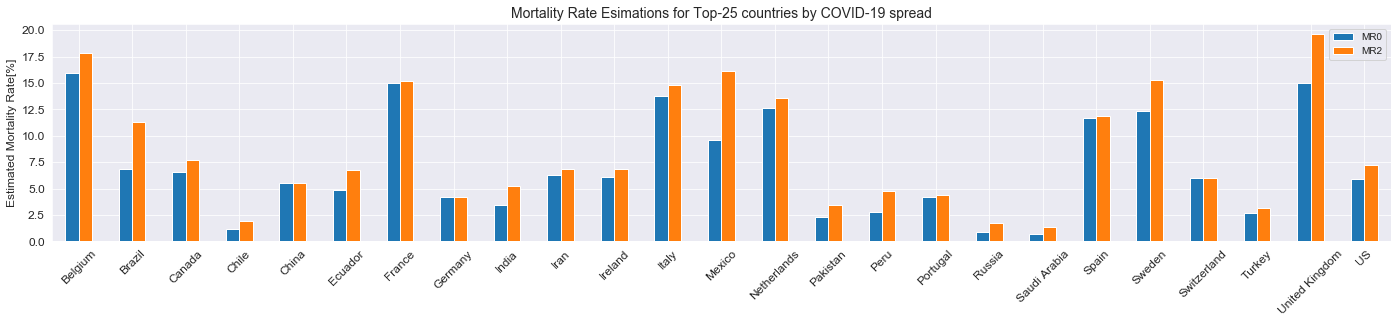

In [1086]:
# World and China
plt.figure(figsize=(24,4))
plt.title("Mortality Rate Esimations: China and World", fontsize=14)
ax = plt.gca()
pd.DataFrame(mr_stats_cw).T.plot(kind='bar',ax=ax)
plt.ylabel('Estimated Mortality Rate[%]', fontsize=12)
x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=0)
plt.setp(y_labels, size=12)
plt.show()

# Top-25 countries by deaths
mr_stats_25 = dict(filter(lambda i: i[0] in countries, mr_stats.items()))
plt.figure(figsize=(24,4))
plt.title("Mortality Rate Esimations for Top-25 countries by COVID-19 spread", fontsize=14)
ax = plt.gca()
pd.DataFrame(mr_stats_25).T.plot(kind='bar',ax=ax)
plt.ylabel('Estimated Mortality Rate[%]', fontsize=12)
x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)
plt.show()

# Modeling COVID-19 dynamics

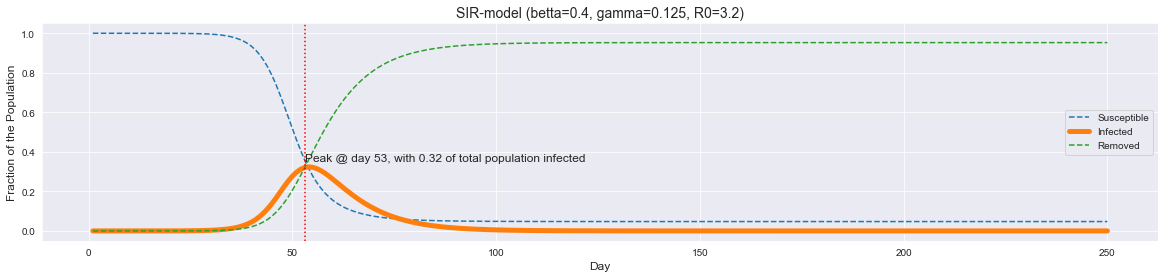

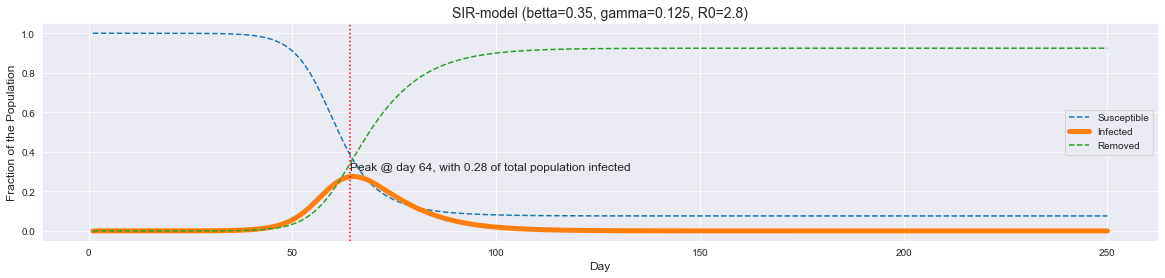

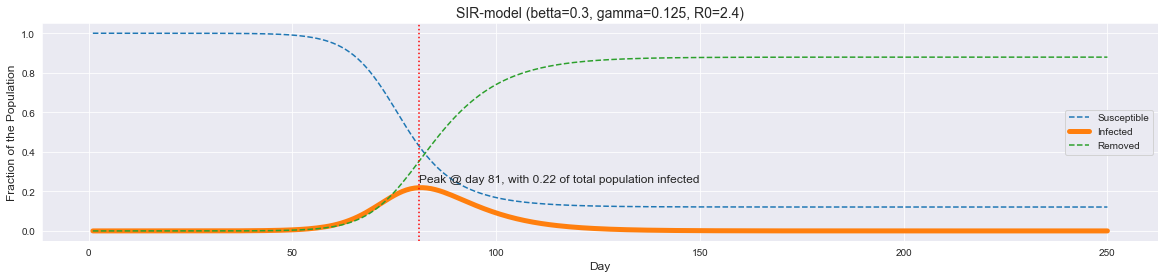

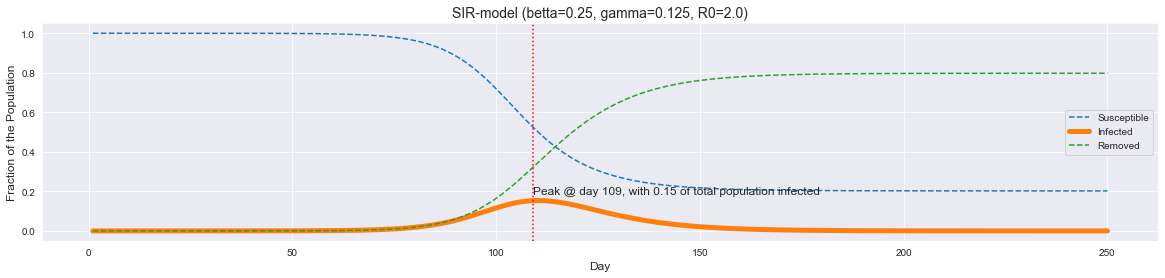

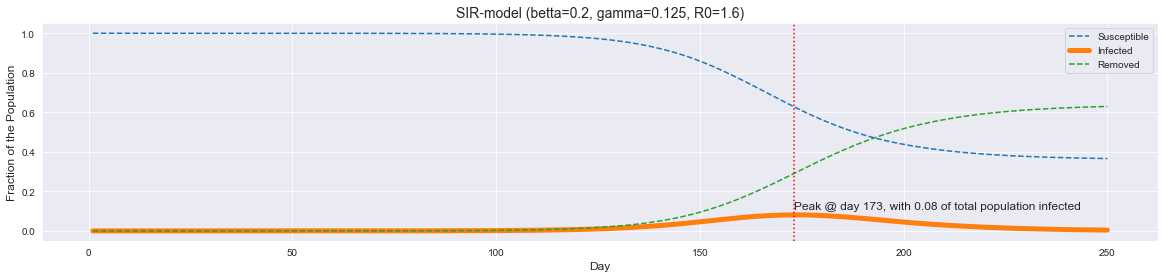

In [1087]:
# SIR Model Simple Example
# SIR Model is the very simple approach to model the epidemics
# it assumes that all individuals fall into different categories
# like S - Susceptible, I - infected, R - Removed
# the rate of transition from state S to state I is beta,
# and the rate of transition from I to R is gamma
# given this rates one can easily write down a system of ODEs
# to describe the evolution of the epidemics in terms of number
# of susceptible / infected / recovered individuals 

# See Wikipedia for a brief description
# https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model

# below is an example of the SIR model 
# (250 days of epidemics with various values of beta),
# that demonstrates the importance of social distancing 
# (i.e. reducing beta) during the pandemics

# Further I will try to apply the SIR model to the COVID-19 data

betta_list = [0.4, 0.35, 0.3, 0.25, 0.2]
for betta in betta_list: 
    # model parameters
    b = betta # infection spread rate
    g = 0.125 # recovery rate

    # number of days
    d = 250

    # initial conditions
    # assuming one of the million people is infected
    s0 = 1-1e-6  
    i0 = 1e-6
    r0 = 0
    y0 = [s0,i0,r0]
    t = list(range(1,d+1))

    def SIR_model(t,y):
        S, I, R = y[0], y[1], y[2]
        return [-b*S*I, b*S*I-g*I, g*I]
    
    # solve SIR-model ODEs
    sol = solve_ivp(SIR_model, [0, d], y0, t_eval=t)

    # plot results
    peak_day = sol.y[1].argmax()
    peak_infected = sol.y[1][peak_day]
    
    plt.figure(figsize=(20,4))
    plt.plot(t,sol.y[0], label='Susceptible', linestyle='--')
    plt.plot(t,sol.y[1], label='Infected', linewidth = 5)
    plt.plot(t,sol.y[2], label='Removed', linestyle='--')
    
    plt.axvline(x = peak_day, c='red', linestyle=':')
    plt.text(peak_day+0.03, peak_infected+0.03, 
             f'Peak @ day {peak_day}, with {round(peak_infected,2)} of total population infected', 
             fontsize=12)
    plt.title(f'SIR-model (betta={b}, gamma={g}, R0={b/g})', fontsize=14)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Fraction of the Population', fontsize=12)
    plt.legend()
    plt.show()

In [1088]:
# SIR Model class
# provides optimization of SIR-models parameters to fit the actual data
# using SIR Model class we can achieve rough estimate of 
# R0 - basic reproductive number for COVID-19

# The key SIR model assumption is that the population is well intermixed 
# and each person has an equal chances to contact eny other person inside
# population. This assumprion is, obviously, wrong in the real World, where
# the density of population is very none-uniform, significant part of World's 
# populatio avoids contating others since the WHO anounced the Pandemic, etc.
# Therefore, I will not use the actual countries populations, 
# but some quantities that are about an order of magnitudes smaller instead
# (chosen to best  fit the data


class SIR_Model(object):
    def __init__(self, country_name, country_population, 
                 country_ts, conf_threshold = 100,
                 eps = 1, model_params=(0,0)):
        """
        SIR-model class
        """
        self.country = country_name
        self.population = country_population
        self.ts = ts_to_sir(country_ts,
                            country_population,
                            conf_threshold)
        self.epsilon = eps
        self.params = model_params
    
    def __repr__(self):
        return (f'SIR_Model({self.country},'
                f'{self.population},\n'
                f'{self.ts.to_string(max_rows=5)},\n' 
                f'{self.epsilon},{self.params})')
    
    def _RMSE_loss(self, point):
        days = len(self.ts)
        y0 = [self.ts['S'][0], self.ts['I'][0], self.ts['R'][0]]
        beta, gamma = point
        
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        
        sol = solve_ivp(SIR, [0, days], y0, t_eval=np.arange(0, days, 1), 
                             vectorized=True)
        
        l1 = np.sqrt(np.mean((sol.y[1] - self.ts['I'])**2))
        l2 = np.sqrt(np.mean((sol.y[2] - self.ts['R'])**2))
        return self.epsilon * l1 + (1 - self.epsilon) * l2
        
    def fit(self):
        optimal = minimize(
            self._RMSE_loss,
            [0.1, 0.01],
            method='L-BFGS-B',
            bounds=[(0.000001, 10), (0.000001, 10)]
        )
        self.params = optimal.x
    
    def predict(self, n_days=0, inplace=True):
        ts_pred = extend_ts(self.ts, n_days)
        days = len(ts_pred)
        y0 = [self.ts['S'][0], self.ts['I'][0], self.ts['R'][0]]
        
        beta, gamma = self.params
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]

        sol = solve_ivp(SIR, [0, days], y0, t_eval=np.arange(0, days, 1),
                        vectorized=True)
        ts_pred['S_pred'] = sol.y[0]
        ts_pred['I_pred'] = sol.y[1]
        ts_pred['R_pred'] = sol.y[2]
        
        if inplace == True:
            self.ts = ts_pred
        else:
            return ts_pred
    
    def plot_model(self, actual, model, dimless=False):
        ts = self.ts
        dates = list(ts.index)
        b = round(self.params[0], 4)
        g = round(self.params[1], 4)
        R0 = round(b/g, 4)
        
        plt.figure(figsize=(24,4))
        plt.title(f'{self.country} | {self.population} | '
                  f'model_beta={b}, model_gamma={g}, '
                  f'model_R0={R0}', fontsize=14)
        plt.ylabel('Infected', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        
        scale = (1 if dimless else self.population)
        
        for col_name, label in actual:             
            data = [it*scale for it in ts[col_name]]
            plt.scatter(dates, data, label=label)

        for col_name, label in model:
            data = [it*scale for it in ts[col_name]]
            plt.plot(dates, data, label=label, linestyle='--')
        
        plt.legend()
        plt.show()

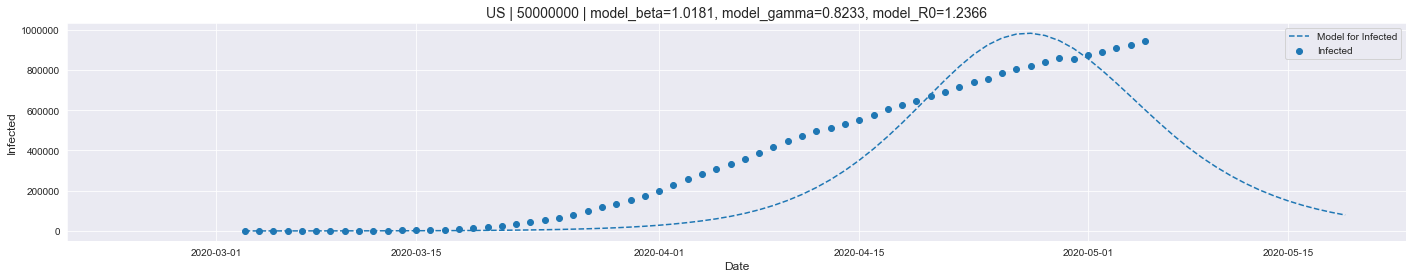

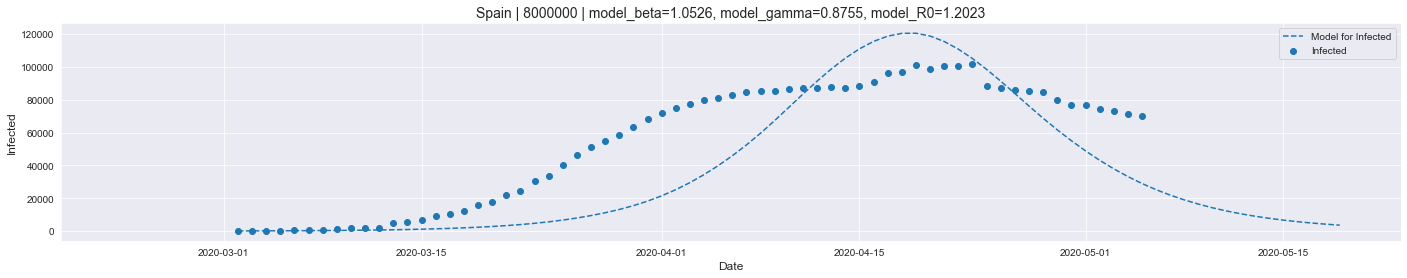

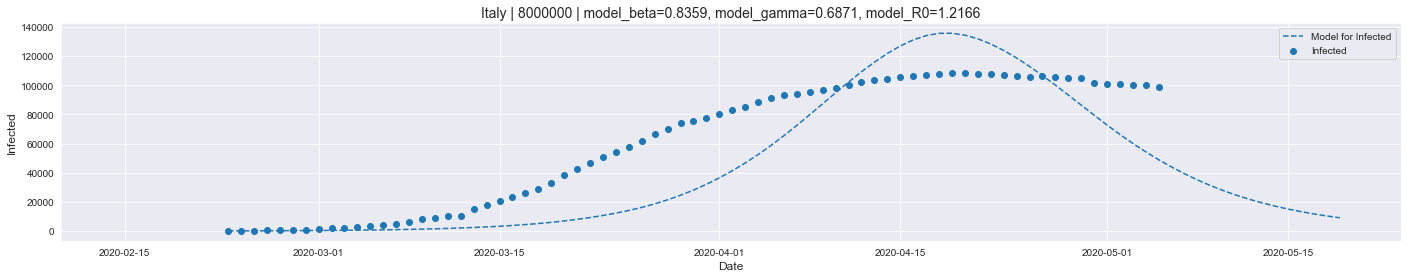

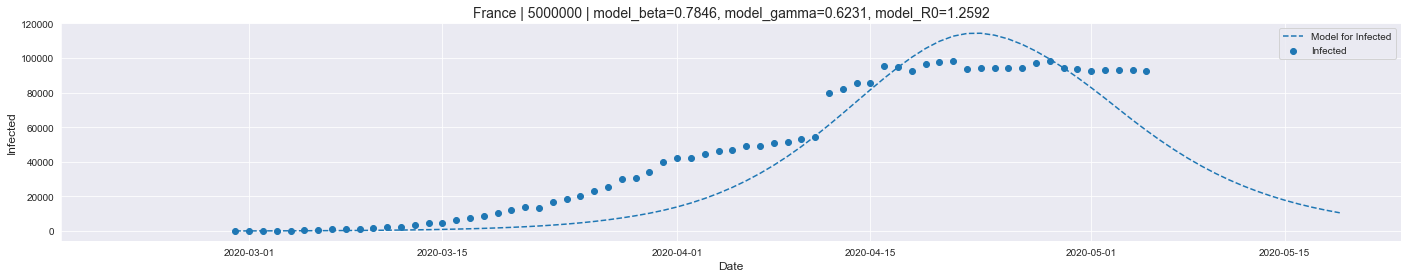

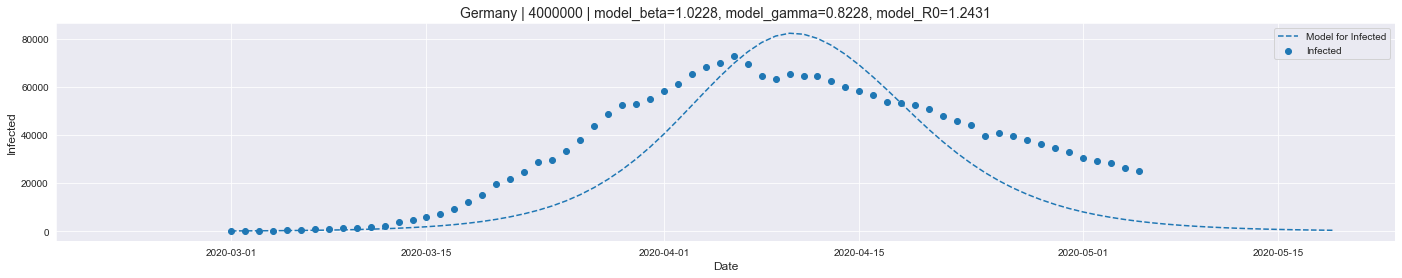

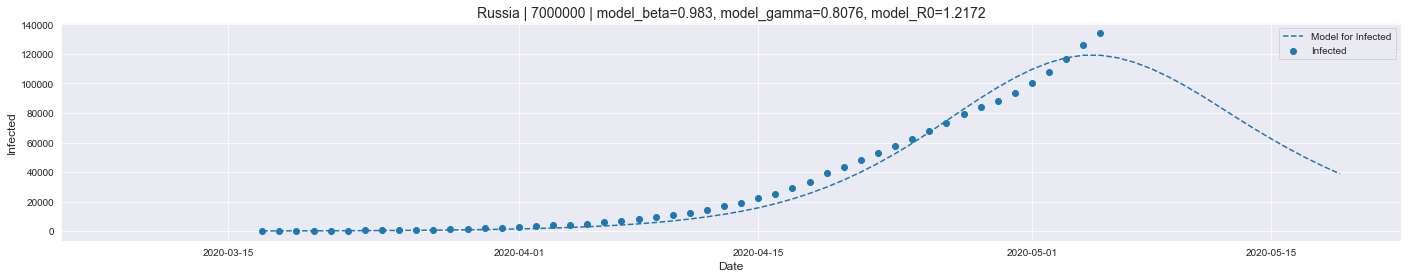

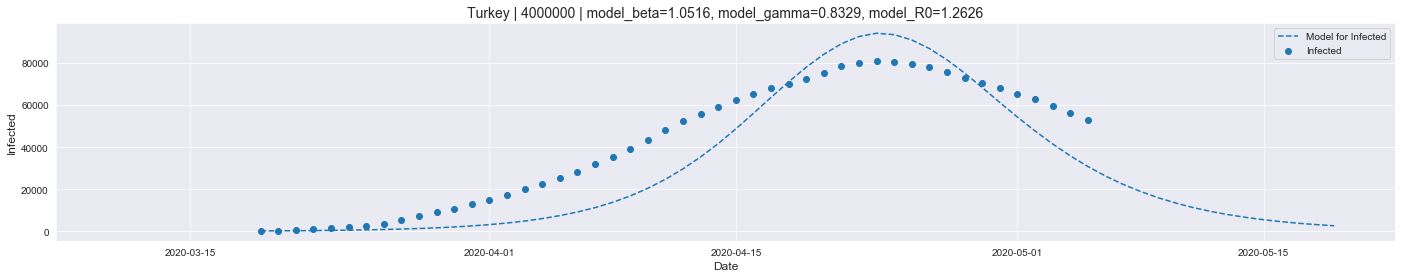

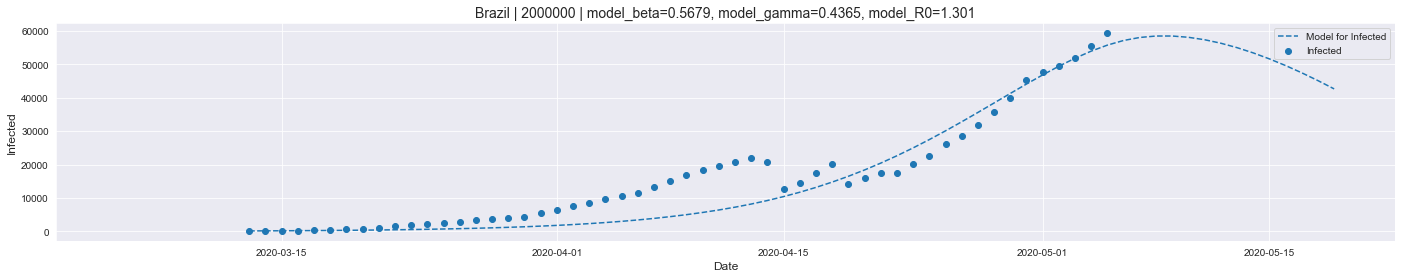

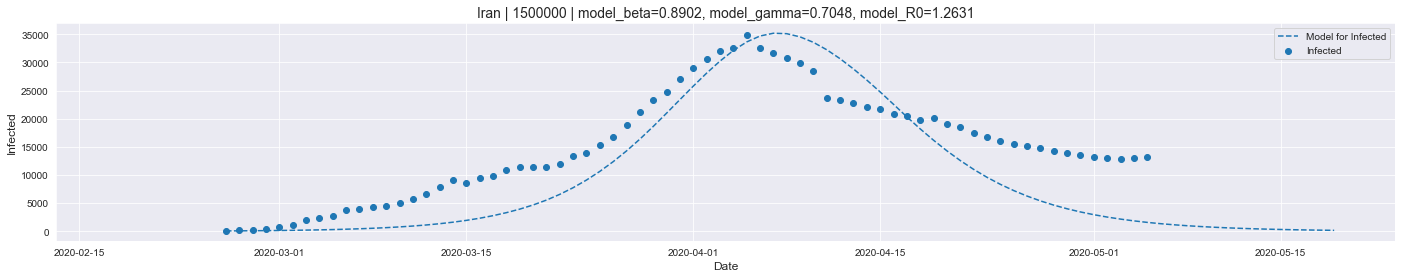

In [1089]:
countries_sir = {'US': 50_000_000,
                 'Spain': 8_000_000,
                 'Italy': 8_000_000,
                 'France': 5_000_000,
                 'Germany': 4_000_000,
                 'Russia': 7_000_000,
                 'Turkey': 4_000_000,
                 'Brazil': 2_000_000,
                 'Iran': 1_500_000}


for country in countries_sir:
    SIR = SIR_Model(country, countries_sir[country], 
                    ts[country], conf_threshold=100, eps=1)
    SIR.fit()
    SIR.predict(14)
    SIR.plot_model([('I','Infected')], 
                   [('I_pred', 'Model for Infected')])
    countries_sir[country] = [round(SIR.params[0],4),
                              round(SIR.params[1],4),
                              round(SIR.params[0]/SIR.params[1],4)]

In [1090]:
SIR_df = pd.DataFrame.from_dict(countries_sir, orient='index',
                               columns=['beta', 'gamma', 'R0'])
SIR_df

,beta,gamma,R0
US,1.0181,0.8233,1.2366
Spain,1.0526,0.8755,1.2024
Italy,0.8359,0.6871,1.2166
France,0.7846,0.6231,1.2592
Germany,1.0228,0.8228,1.2430
Russia,0.9830,0.8076,1.2172
Turkey,1.0516,0.8329,1.2626
Brazil,0.5679,0.4365,1.3009
Iran,0.8902,0.7048,1.2630


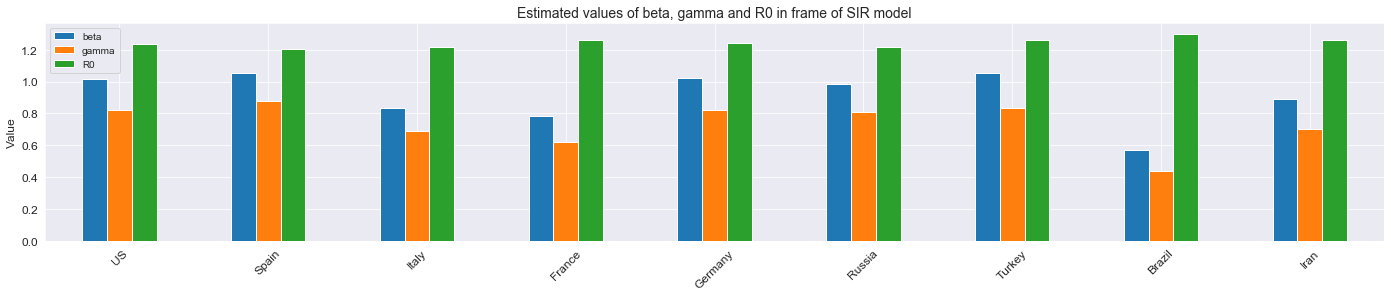

In [1091]:
plt.figure(figsize=(24,4))
plt.title("Estimated values of beta, gamma and R0 in frame of SIR model", fontsize=14)
ax = plt.gca()
SIR_df.plot(kind='bar',ax=ax)
plt.ylabel('Value', fontsize=12)
x_locs, x_labels = plt.xticks()
y_locs, y_labels = plt.yticks()
plt.setp(x_labels, size=12, rotation=45)
plt.setp(y_labels, size=12)
plt.show()